In [1]:
%reload_ext autoreload

# Imports

import os
import sys
module_path = os.path.abspath(os.path.join('../image_gen_dm')) # or the path to your source code
sys.path.append(str(module_path))

import tensorflow as tf
import tf_keras as tfk
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

tfkl = tfk.layers
tfpl = tfp.layers
tfd = tfp.distributions

TF_ENABLE_ONEDNN_OPTS=0
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(TF_ENABLE_ONEDNN_OPTS)
os.environ['TG_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import denoising_vae as dvae
import denoising_vae.constants as consts

print('Tensorflow Version:', tf.__version__)
print("Available GPUs: ", len(tf.config.list_physical_devices('GPU')))

2024-05-03 20:18:14.531328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 20:18:19.162837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 20:18:19.178168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 20:18:19.178217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUM

Tensorflow Version: 2.16.1
Available GPUs:  1


In [2]:
# Constants

IMAGE_SIZE = 64

ENCODER_HIDDEN_SIZES = [1792, 1152, 448]
DECODER_HIDDEN_SIZES = ENCODER_HIDDEN_SIZES[::-1]

ENCODER_CONV_CONFIG = [(112, 3, 2), (224, 3, 2), (576, 3, 2), (1152, 3, 2), (2048, 3, 2)]
DECODER_CONV_CONFIG = ENCODER_CONV_CONFIG[::-1]

FLATTENED_SHAPE = (2, 2, 2048)
FLATTENED_SIZE = 2048 * 2 * 2

LATENT_DIM = 2

MODEL_NAME = 'cvae'
ENCODER_FILE_PATH = f'res/models/{MODEL_NAME}_encoder.h5'
DECODER_FILE_PATH = f'res/models/{MODEL_NAME}_decoder.h5'

LEARNING_RATE = 1e-4
VAL_PERCENTAGE = 0.1

In [3]:
# Dataset loading

train_ds, val_ds = dvae.utils.load_datasets(val_percentage=VAL_PERCENTAGE)

Loading datasets...
Training Images:  8100
Evaluation Images:  900
Training Images (post-duplication):  8100
Validation Images (post-duplication):  900


In [4]:
# Model class

# This code is heavily based on the Keras Team's example on Convolutional VAEs with only minor modifications.
# The original code can be found at: https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

# Author: [fchollet](https://twitter.com/fchollet)
# Licensed under the Apache License 2.0. See LICENSE file in the root directory for more information.


class Sampling(tfkl.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class CVAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            input_data, target_data = data
            noise_levels = tf.random.uniform(shape=(consts.BATCH_SIZE,), minval=0, maxval=consts.NOISE_LEVELS - 1, dtype=tf.int32)

            def apply_noise_to_image(image, noise_level):
                return dvae.utils.apply_noise(image, noise_level)
            
            input_data_noisy = tf.map_fn(
                lambda x: apply_noise_to_image(x[0], x[1]), 
                (input_data, noise_levels), dtype=tf.float32)

            z_mean, z_log_var, z = self.encoder(input_data_noisy)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.losses.binary_crossentropy(target_data, reconstruction), 
                    axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, input_data, training=False):
        _, _, z = self.encoder(input_data)
        reconstructed_image = self.decoder(z)

        return reconstructed_image


In [5]:
# Encoder

image_input = tfkl.Input(shape=consts.INPUT_SHAPE, name='image_input')

x = image_input
for filters, kernel_size, strides in ENCODER_CONV_CONFIG:
    x = tfkl.Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), strides=(strides, strides), activation='relu', padding='same')(x)

flattened_image = tfkl.Flatten()(x)

x = flattened_image
for layer_size in ENCODER_HIDDEN_SIZES:
    x = tfkl.Dense(layer_size, 
            activation='relu',
            kernel_initializer='glorot_uniform')(x)
    
z_mean = tfkl.Dense(LATENT_DIM, name='z_mean', kernel_initializer='glorot_uniform')(x)
z_log_var = tfkl.Dense(LATENT_DIM, name='z_log_var', kernel_initializer='glorot_uniform')(x)

z = Sampling()([z_mean, z_log_var])

encoder = tfk.Model(inputs=image_input, outputs=[z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder

latent_inputs = tfkl.Input(shape=(LATENT_DIM,))

y = latent_inputs
for layer_size in DECODER_HIDDEN_SIZES:
    y = tfkl.Dense(layer_size, 
            activation='relu',
            kernel_initializer='glorot_uniform')(y)
    
reconstructed_flattened_image = tfkl.Dense(FLATTENED_SIZE, kernel_initializer='glorot_uniform', activation='relu')(y)

y = tfkl.Reshape(FLATTENED_SHAPE)(reconstructed_flattened_image)

j = 0
for filters, kernel_size, strides in DECODER_CONV_CONFIG:
    if j == len(DECODER_CONV_CONFIG) - 1:
        y = tfkl.Conv2DTranspose(filters=3, kernel_size=(kernel_size, kernel_size), strides=(strides, strides), activation='sigmoid', padding='same')(y)
    else:
        y = tfkl.Conv2DTranspose(filters=DECODER_CONV_CONFIG[j + 1][0], kernel_size=(kernel_size, kernel_size), strides=(strides, strides), activation='relu', padding='same')(y)
    j += 1

decoder = tfk.Model(inputs=latent_inputs, outputs=y, name='decoder')
decoder.summary()

# Model
    
model = CVAE(encoder, decoder)
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE))


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 112)          3136      ['image_input[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 224)          226016    ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 8, 8, 576)            1161792   ['conv2d_1[0][0]']            
                                                                                            

In [6]:
# Load weights

if os.path.exists(ENCODER_FILE_PATH) and os.path.exists(DECODER_FILE_PATH):
    encoder.load_weights(ENCODER_FILE_PATH)
    decoder.load_weights(DECODER_FILE_PATH)
else:
    print('No weights found')
    

In [7]:
# Run model

epochs = 1024

history = dvae.run_model(model=model, train_ds=train_ds, val_ds=val_ds, epochs=epochs, name=MODEL_NAME, plot=False, time=True)

file_path = f'res/histories/{MODEL_NAME}.csv'

history_df = pd.DataFrame(history.history)

if os.path.exists(file_path):
    df = pd.read_csv(file_path)

    last_time = df['elapsed_time'].iloc[-1]
    history_df['elapsed_time'] += last_time

    history_df.to_csv(file_path, mode='a', header=False, index=False)
else:
    history_df.to_csv(file_path, mode='w', header=True, index=False)
    
# dvae.save_latent_space(model=model, model_name=MODEL_NAME)

encoder.save_weights(ENCODER_FILE_PATH)
decoder.save_weights(DECODER_FILE_PATH)


Epoch 1/1024
Instructions for updating:
Use fn_output_signature instead


2024-05-03 20:18:43.894862: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-05-03 20:18:48.173247: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1714767529.099121     162 service.cc:145] XLA service 0x7f03353485a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714767529.099225     162 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-03 20:18:49.126026: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714767529.285254     162 device_compiler.h:188] Compiled cluste

63/64 [============================>.] - ETA: 0s - loss: 2569.5156 - reconstruction_loss: 2561.3459 - kl_loss: 8.1821

2024-05-03 20:19:08.235707: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


64/64 [==============================] - 46s 323ms/step - loss: 2569.5167 - reconstruction_loss: 2561.3713 - kl_loss: 8.1802 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - elapsed_time: 46.4339
Epoch 2/1024
64/64 [==============================] - 16s 243ms/step - loss: 2569.3259 - reconstruction_loss: 2562.2681 - kl_loss: 8.1839 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - elapsed_time: 62.1728
Epoch 3/1024
64/64 [==============================] - 15s 241ms/step - loss: 2570.8626 - reconstruction_loss: 2564.0276 - kl_loss: 8.1521 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - elapsed_time: 77.6148
Epoch 4/1024
64/64 [==============================] - 15s 241ms/step - loss: 2572.8044 - reconstruction_loss: 2563.6655 - kl_loss: 8.0913 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - elapsed_time: 9

In [8]:
# Save model weights

encoder.save_weights(ENCODER_FILE_PATH)
decoder.save_weights(DECODER_FILE_PATH)

In [9]:
# Load csv file

csv_file = f'res/histories/{MODEL_NAME}.csv'
df = pd.read_csv(csv_file)

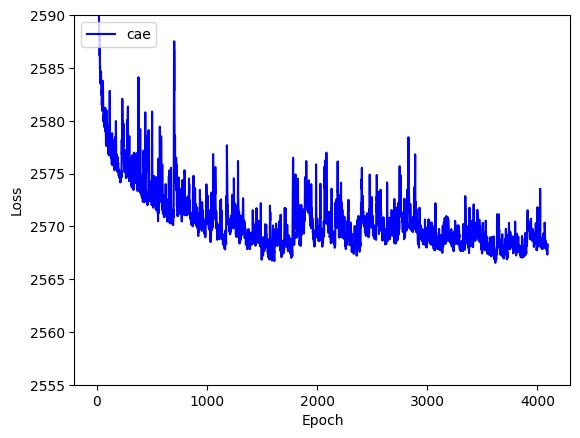

In [10]:
# Plot loss

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.ylim(2555, 2590)

plt.plot(df['loss'], label='cae', color='blue')
plt.legend(loc="upper left")

plt.show()

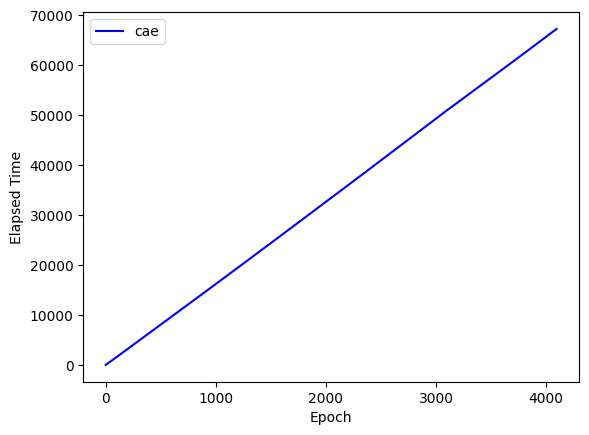

In [11]:
# Plot elapsed time

plt.ylabel('Elapsed Time')
plt.xlabel('Epoch')

plt.plot(df['elapsed_time'], label='cae', color='blue')

plt.legend(loc="upper left")

plt.show()

Loading examples...


2024-05-04 00:58:21.313817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


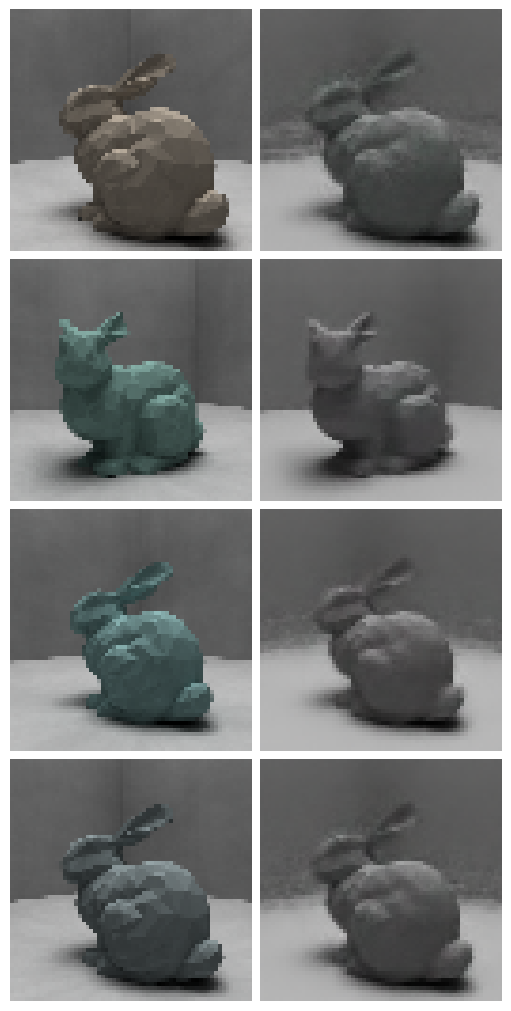

In [12]:
# Validate model

dvae.val_model(model=model)

In [13]:
# Plot latent space

# dvae.plot_latent_space(model=model, start=-1, stop=1)

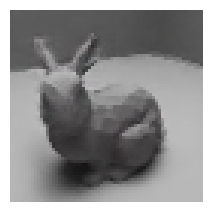

In [14]:
# Generate single image

_ = dvae.gen_image(model=model)

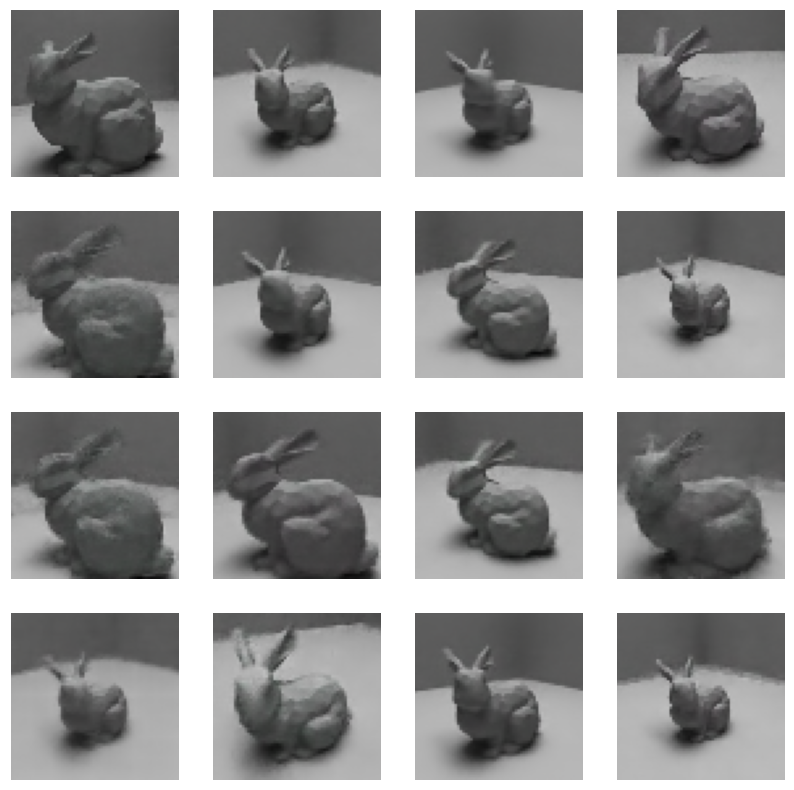

In [15]:
# Generate multiple images

dvae.gen_images(model=model, count=16, min=-2.5, max=2.5)